In [ ]:
# Experiment loop:
# 1) Train baseline once
# 2) Freeze weights (by copying state_dict)
# 3) Replace ReLU with FT-ReLU
# 4) Sweep one noise type at a time (no cross-interactions since they're worse together)

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from threeSpiral import (
    make_3_spirals, train, accuracy,
    MLP, FaultTolerantReLU, FTReluConfig, replace_relu_with_ftrelu,
)

device = "cpu"
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)


# Data -------------------------

X, y = make_3_spirals(n_per_class=600, noise=0.25, seed=seed)
idx = np.random.permutation(len(X))
split = int(0.8 * len(X))
tr, te = idx[:split], idx[split:]

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[tr]), torch.from_numpy(y[tr])),
    batch_size=256, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[te]), torch.from_numpy(y[te])),
    batch_size=256, shuffle=False
)


# 1) Train baseline ONCE -------------------------

baseline = MLP(in_dim=2, hidden=32, out_dim=3)
train(baseline, train_loader, test_loader, device, epochs=1000, lr=1e-3)
baseline_acc = accuracy(baseline, test_loader, device)
print(f"\nBaseline test accuracy: {baseline_acc:.4f}")

baseline_state = {k: v.detach().cpu().clone() for k, v in baseline.state_dict().items()}


# FT config (shared) -------------------------

x_min, x_max = -26.0, 14.0
S = 101  # use larger value for final plots; 100 is faster for sweeps

# Define sweeps (edit ranges as you like)
sweeps = {
    "sigma_trig":  [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2],
    "sigma_score": [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2],
    "p_syn":       [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2],
    # sigma_phase is known to be problematic in this architecture; included only as a demonstration
    "sigma_phase": [0.0, 0.05, 0.1],
}

results = {k: [] for k in sweeps.keys()}

def eval_ft_with_noise(noise_name: str, noise_val: float) -> float:
    model = MLP(in_dim=2, hidden=32, out_dim=3)
    model.load_state_dict(baseline_state)

    cfg = FTReluConfig(
        x_min=x_min, x_max=x_max, S=S,
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p_syn=0.0,
    )

    # set exactly one noise knob
    setattr(cfg, noise_name, float(noise_val))

    replace_relu_with_ftrelu(model, FaultTolerantReLU(cfg))
    return accuracy(model, test_loader, device)


# 4) Run one-noise-at-a-time sweeps -------------------------

for noise_name, vals in sweeps.items():
    print(f"\n=== Sweeping {noise_name} (others = 0) ===")
    for v in vals:
        acc = eval_ft_with_noise(noise_name, v)
        results[noise_name].append((v, acc))
        print(f"{noise_name}={v:.3e} -> FT acc={acc:.4f} | baseline={baseline_acc:.4f}")

# `results` now contains all sweep data for plotting.
# Example: results["sigma_trig"] = [(0.0, acc0), (0.01, acc1), ...]

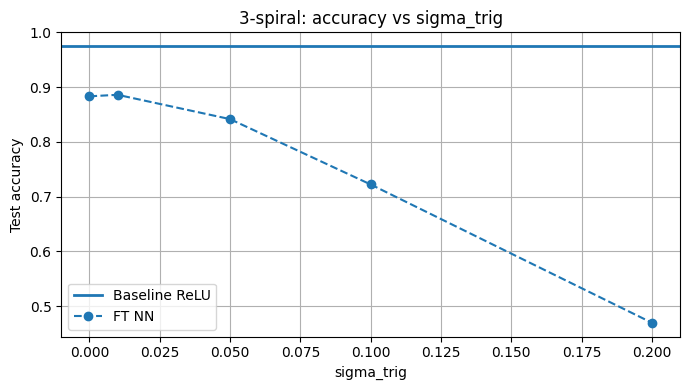

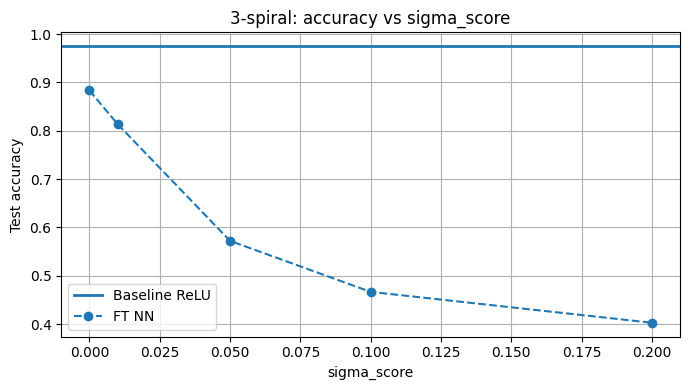

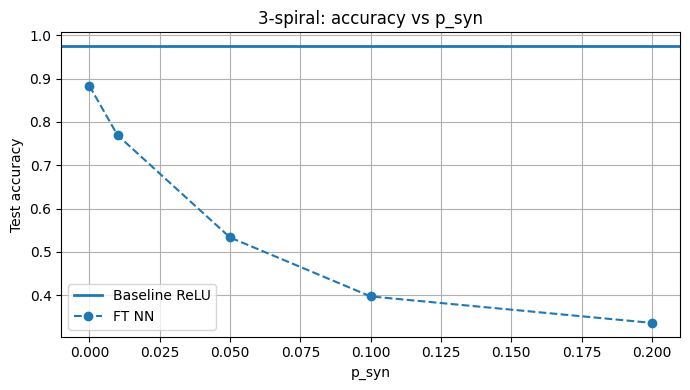

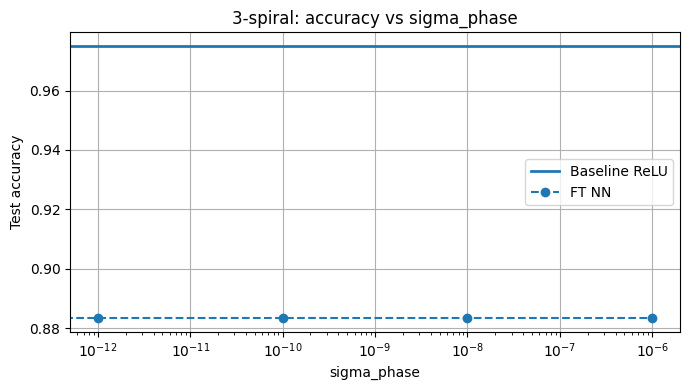

In [3]:
import matplotlib.pyplot as plt

# results: dict like {"sigma_trig":[(v,acc),...], "sigma_score":[...], "p_syn":[...], "sigma_phase":[...]}
# baseline_acc: float

noise_order = ["sigma_trig", "sigma_score", "p_syn", "sigma_phase"]

for noise_name in noise_order:
    if noise_name not in results or len(results[noise_name]) == 0:
        continue

    xs = [v for v, a in results[noise_name]]
    ys = [a for v, a in results[noise_name]]

    plt.figure(figsize=(7,4))
    plt.axhline(baseline_acc, linewidth=2, label="Baseline ReLU")

    # log-scale only makes sense for sigma_phase sweeps with tiny values
    if noise_name == "sigma_phase":
        plt.plot(xs, ys, "o--", label="FT NN")
        plt.xscale("log")
    else:
        plt.plot(xs, ys, "o--", label="FT NN")

    plt.xlabel(noise_name)
    plt.ylabel("Test accuracy")
    plt.title(f"3-spiral: accuracy vs {noise_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()